In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [3]:
# I used the dataset hosted at https://www.kaggle.com/melvincheung/hong-kong-marathon-2016
# Read in the csv
run_results = pd.read_csv("challenge.csv")
run_results.columns = run_results.columns.str.strip()

In [4]:
# Top 5 lines from the csv
run_results.head()

,Overall Position,Gender Position,Category Position,Category,Race No,Country,Official Time,Net Time,10km Time,Half Way Time,30km Time
0,1,1,1,MMS,21080,Kenya,2:12:12,2:12:11,0:30:35,1:04:48,1:33:36
1,2,2,1,MMI,14,Kenya,2:12:14,2:12:13,0:30:34,1:04:48,1:33:36
2,3,3,2,MMI,2,Ethiopia,2:12:20,2:12:18,0:30:35,1:04:49,1:33:36
3,4,4,2,MMS,21077,Kenya,2:12:29,2:12:27,0:30:35,1:04:48,1:33:36
4,5,5,3,MMI,18,Ethiopia,2:12:47,2:12:46,0:30:34,1:04:48,1:33:36


In [5]:
# How many rows/athletes there are
run_results.shape[0]

5616

In [6]:
# Convert each time column from string to time. Print the average from each column as a sanity check
for col in run_results.loc[:,'Official Time':'30km Time'].columns:
        run_results.loc[:,col] = pd.to_timedelta(run_results.loc[:,col])
print("Average Times:")
print(run_results.loc[:,'Official Time':'30km Time'].mean())

# Check the difference between the minimum and maximum for each column
print("Difference in first and last time for each time segment:")
for col in run_results.loc[:,'Official Time':'30km Time'].columns:
    print(col)
    print(run_results[col].max() - run_results[col].min())

Average Times:
Official Time   0 days 04:28:58.604522792
Net Time        0 days 04:27:04.405092592
10km Time       0 days 01:01:16.393577163
Half Way Time   0 days 02:06:34.927220834
30km Time       0 days 03:03:02.151855817
dtype: timedelta64[ns]
Difference in first and last time for each time segment:
Official Time
0 days 03:54:52
Net Time
0 days 03:47:31
10km Time
0 days 01:05:31
Half Way Time
0 days 01:59:01
30km Time
0 days 02:51:50


In [7]:
# Add the gender, as derived from the category
run_results['Gender'] = run_results.Category.str[1]

<AxesSubplot:xlabel='Country'>

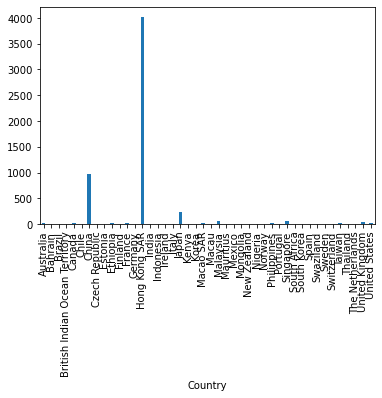

In [8]:
# Representation by country
country_counts = run_results.groupby('Country').size()
country_counts.plot.bar()

<AxesSubplot:title={'center':'Overall Position'}, xlabel='[Gender]'>

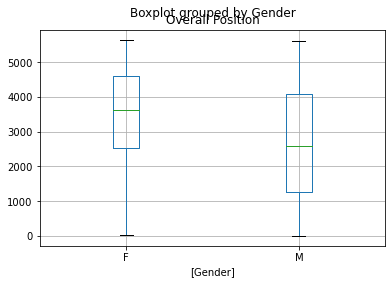

In [9]:
# Box plot of finishing place by gender
df = run_results[['Overall Position','Gender']]
df.boxplot(by='Gender')

<AxesSubplot:xlabel='Official Time,Gender,GenderColor'>

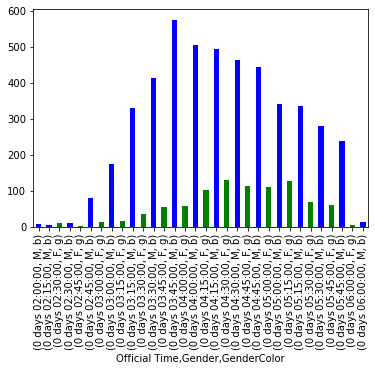

In [10]:
# Grouped barchart of overall time by gender
run_results['GenderColor'] = run_results.Gender.apply(lambda x: 'b' if x == 'M' else 'g')

df = run_results.groupby([run_results['Official Time'].dt.floor('15min'),'Gender','GenderColor']).size()
df.plot.bar(color = [key[2] for key in df.keys()])


<AxesSubplot:xlabel='Official Time,Category,CategoryColor'>

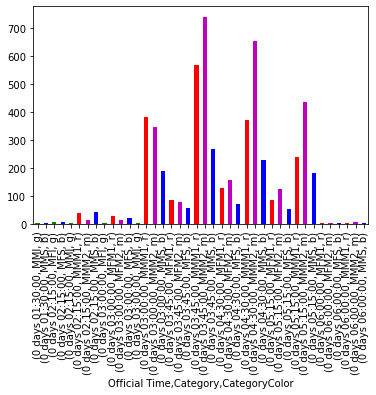

In [11]:
# List the categories 
run_results.Category.unique()

# A function to color the categories based on equivalent groups across gender
def colorCategory(category):
    if category == 'MMS' or category == 'MFS':
            col = 'b'
    elif category == 'MMI' or category == 'MFI':
            col = 'g'
    elif category == 'MMM1' or category == 'MFM1':
            col = 'r'
    else:
            col = 'm'
    return col

# Run the function to create the category color column
run_results['CategoryColor'] = run_results.Category.apply(lambda x: colorCategory(x))
df = run_results.groupby([run_results['Official Time'].dt.floor('45min'),'Category','CategoryColor']).size()
df.plot.bar(color = [key[2] for key in df.keys()])

<AxesSubplot:>

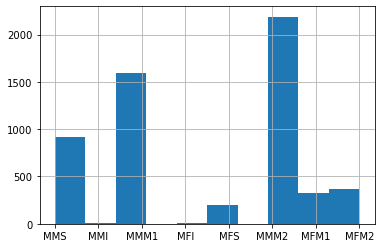

In [12]:
run_results.Category.hist()

In [13]:
# Function to determine the pace for the first half. Just the first half time divided by distance (21.1 km)
def firstHalfPace(halfwaytime):
    return halfwaytime / 21.1

# Function to determine the pace for the second half. (Official time - first half) / 21.1
def secondHalfPace(officialtime, halfwaytime):
    return (officialtime - halfwaytime) / 21.1

# Function to take the difference of the pace between the second and the first half
def halfDiff(SecondHalfPace, FirstHalfPace):
    return SecondHalfPace.total_seconds() - FirstHalfPace.total_seconds()

run_results['First Half Pace'] = run_results['Half Way Time'].apply(lambda x: firstHalfPace(x))
run_results['Second Half Pace'] = run_results.apply(lambda x: secondHalfPace(x['Official Time'],x['Half Way Time']),axis = 1)
run_results['Half Pace Difference'] = run_results.apply(lambda x: halfDiff(x['Second Half Pace'],x['First Half Pace']),axis = 1)

<AxesSubplot:xlabel='First Half Pace', ylabel='Second Half Pace'>

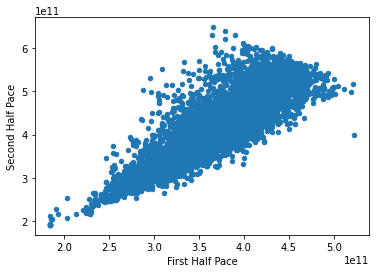

In [14]:
# Plotting the first half pace vs the second half pace
run_results.plot.scatter(x = 'First Half Pace', y = 'Second Half Pace')

46.54791967460149
36.52208444062153
7.496326110763163
1.0961738712508242e-13


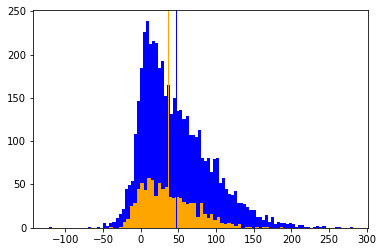

In [23]:
df_men = run_results.loc[run_results['Gender'] == 'M','Half Pace Difference']
df_women = run_results.loc[run_results['Gender'] == 'F','Half Pace Difference']

print(df_men.mean())
print(df_women.mean())
t, p = stats.ttest_ind(df_men,df_women,equal_var = False, nan_policy = 'omit')
print(t)
print(p)

plt.hist(df_men, bins = 100, color = 'blue')
plt.axvline(df_men.mean(), color = 'blue', linewidth=1)
plt.hist(df_women, bins = 50, color = 'orange')
plt.axvline(df_women.mean(), color = 'orange', linewidth=1)

MMS
       Half Pace Difference
count            918.000000
mean              50.866658
std               52.277830
min              -67.014218
25%               10.627962
50%               40.355450
75%               82.808057
max              281.800948


MMI
       Half Pace Difference
count              8.000000
mean              12.612560
std               15.920774
min               -8.388625
25%                6.587678
50%                8.364929
75%               14.324645
max               43.412323


MMM1
       Half Pace Difference
count           1596.000000
mean              41.774994
std               43.755274
min              -54.265403
25%                9.075829
50%               30.450237
75%               66.552133
max              263.649289


MFI
       Half Pace Difference
count              7.000000
mean              -4.346649
std               12.153933
min              -13.033176
25%              -12.109005
50%               -9.715640
75%               -0.8530

<AxesSubplot:title={'center':'Half Pace Difference'}, xlabel='[Category]'>

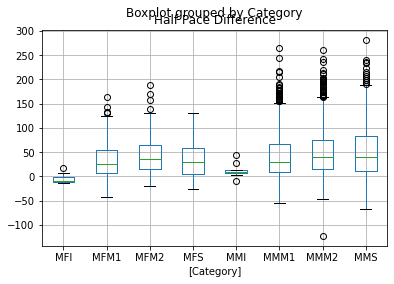

In [224]:
# Compare the average split distance by category using descibe. plot it using a boxplot

for cat in run_results.Category.unique():
    df = run_results.loc[run_results['Category'] == cat]
    print(cat)
    print(df[['Half Pace Difference']].describe())
    print("\n")

run_results[['Half Pace Difference','Category']].boxplot(by='Category')

